In [1]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from scipy.stats import randint
import logomaker as lg 


In [2]:
# importing data from tsv
with open('C:/Users/loekd/OneDrive/Documenten/SearchTable-2024-02-06 12_24_08.532.tsv', 'r') as file:
    VDJDB_data = pd.read_csv(file, sep='\t')
    

In [3]:
# functions used in this file
def count_types_column(frame, column, types):
    class_count = {}
    for sort in types:
        count = 0
        for i in frame[column]:
            if sort == i:
                count += 1
        class_count[sort] = count
    return class_count


def list_all_values_df(frame, culumn):
    all_values = []
    for value in frame[culumn]:
        if value not in all_values:
            all_values.append(value)
    return all_values


def remove_after_character_in_df(frame, column, char):
     frame.loc[:, column] = frame[column].apply(lambda text: text.split(char)[0])
     

def get_column_values(df, criteria1, criteria2):
    # Filtering the DataFrame based on the criteria
    filtered_df = df[(df['Gene'] == criteria1) & (df['MHC A'] == criteria2)]

    # Extracting the column into a list
    desired_list = filtered_df['CDR3'].tolist()
    
    return desired_list


def count_amino_acids(sequences):
    # Initialize a dictionary to store counts
    counts = {}

    # Iterate through each sequence
    for seq in sequences:
        # Iterate through each position in the sequence
        for i, aa in enumerate(seq):
            # Check if the position is already in the dictionary
            if i not in counts:
                # If not, initialize the count for this position
                counts[i] = {}
            
            # Increment the count for this amino acid at this position
            counts[i][aa] = counts[i].get(aa, 0) + 1
    
    # Convert counts dictionary to a DataFrame
    df = pd.DataFrame(counts).fillna(0).astype(int)

    # Reorder columns by amino acid
    df = df.reindex(sorted(df.columns), axis=1)
    
    # Transpose the DataFrame so that amino acids are in columns
    df = df.transpose()
    return df


def calculate_relative_frequency(df):
    # Calculate the sum of absolute frequencies per row
    row_sums = df.sum(axis=1)
    
    # Divide each absolute frequency value by the sum for its respective row
    relative_df = df.div(row_sums, axis=0)
    
    return relative_df


def encode_protseq(new_seq, values):
    encoded_sequence = [values[amino] for amino in new_seq]
    return encoded_sequence


def encode_df_column(frame, column, values):
    frame[column] = frame[column].apply(lambda seq: encode_protseq(seq, values))


def split_list_column_inplace(frame, column_name):
    # Extract the column containing lists
    list_column = frame[column_name]

    # Create new columns for each element in the list
    max_list_length = list_column.apply(len).max()
    new_columns = [f"{column_name}_{i + 1}" for i in range(max_list_length)]

    # Split the list into separate columns and add them to the same DataFrame
    frame[new_columns] = pd.DataFrame(list_column.tolist(), index=frame.index)

    # Drop the original list column inplace
    frame.drop(columns=[column_name], inplace=True)
    
def encode_df_column_binary(frame, column, value):
    frame[column] = frame[column].apply(lambda x: 1 if x == value else 0)

84388
63662


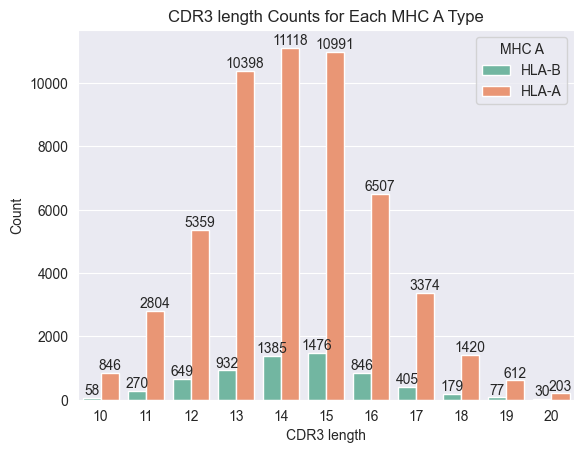

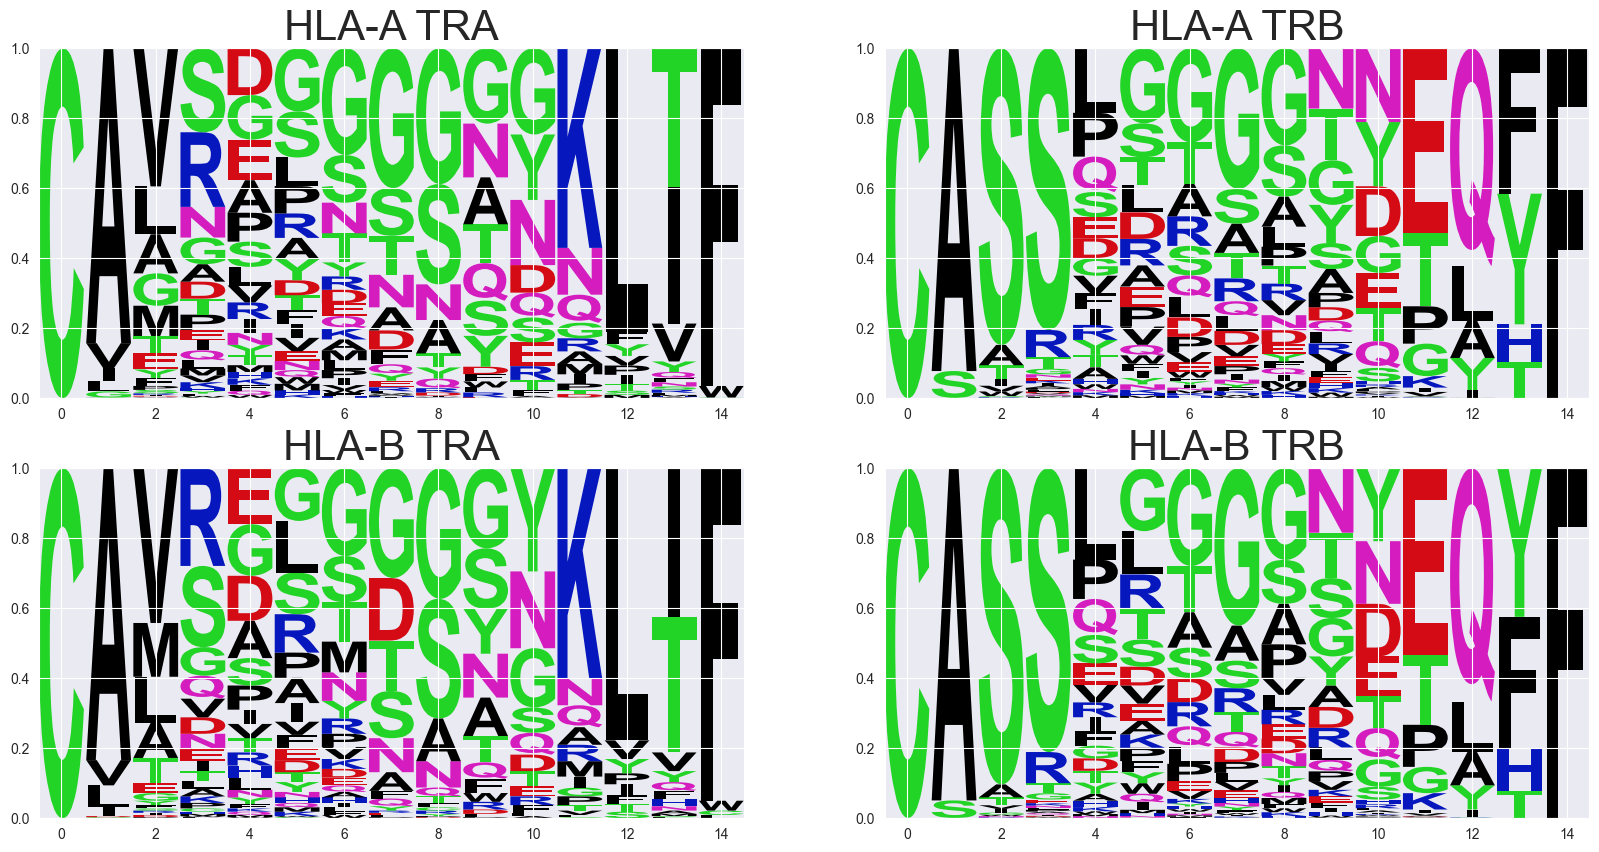

In [4]:
# filter dataframe on unique sequences
print(len(VDJDB_data))
VDJDB_data_unique = VDJDB_data.drop_duplicates(subset=['CDR3'])
print(len(VDJDB_data_unique))
remove_after_character_in_df(VDJDB_data_unique, 'MHC A', '*')

# filter ony on HlA A and HLA B
VDJDB_data_unique.loc[:, 'MHC A'] = VDJDB_data_unique['MHC A'].astype(str)

# Filter the DataFrame and assign the filtered results to a new DataFrame
VDJDB_data_filtered = VDJDB_data_unique.loc[(VDJDB_data_unique['MHC A'] == "HLA-A") | (VDJDB_data_unique['MHC A'] == "HLA-B")]
VDJDB_data_filtered2 = VDJDB_data_filtered.loc[(VDJDB_data_filtered['CDR3'].str.len() >= 10) & (VDJDB_data_filtered['CDR3'].str.len() <= 20)]

# total amount of MHC A distribution in a plot


# make length distribution devided by HLA type
barplot_df = VDJDB_data_filtered2[['CDR3', 'MHC A']]
barplot_df.loc[:,'CDR3'] = barplot_df['CDR3'].str.len()

# Plot barplot seperated by mhc type
ax = sns.countplot(x='CDR3', hue='MHC A', data=barplot_df, palette='Set2')

# adding counts to bars
for i in ax.containers:
    ax.bar_label(i,)
    
# Add labels and title
plt.xlabel('CDR3 length')
plt.ylabel('Count')
plt.title('CDR3 length Counts for Each MHC A Type')

# Show plot
plt.savefig('plots/MHCA_lengthdistribution.png')

# make sequence logos from HLA types and TCR type
# filter on 1 length
VDJDB_data_filtered3 = VDJDB_data_filtered2.loc[(VDJDB_data_filtered2['CDR3'].str.len() == 15)]
# split all data into the different groups
HLAA_TRA = get_column_values(VDJDB_data_filtered3, 'TRA', 'HLA-A')
HLAA_TRB = get_column_values(VDJDB_data_filtered3, 'TRB', 'HLA-A')
HLAB_TRA = get_column_values(VDJDB_data_filtered3, 'TRA', 'HLA-B')
HLAB_TRB = get_column_values(VDJDB_data_filtered3, 'TRB', 'HLA-B')
# make relative 
HLAA_TRA = count_amino_acids(HLAA_TRA)
HLAA_TRB = count_amino_acids(HLAA_TRB)
HLAB_TRA = count_amino_acids(HLAB_TRA)
HLAB_TRB = count_amino_acids(HLAB_TRB)
HLAA_TRA = calculate_relative_frequency(HLAA_TRA)
HLAA_TRB = calculate_relative_frequency(HLAA_TRB)
HLAB_TRA = calculate_relative_frequency(HLAB_TRA)
HLAB_TRB = calculate_relative_frequency(HLAB_TRB)
# initiate figure
fig, axes = plt.subplots(2,2, figsize=(20,10))
# sequence logo 1
lg.Logo(HLAA_TRA, ax=axes[0,0])
axes[0,0].set_title('HLA-A TRA', fontsize=30)
# sequence logo 2
lg.Logo(HLAA_TRB, ax=axes[0,1])
axes[0,1].set_title('HLA-A TRB', fontsize=30)
# sequence Logo 3
lg.Logo(HLAB_TRA, ax=axes[1,0])
axes[1,0].set_title('HLA-B TRA', fontsize=30)
# sequence logo 4
lg.Logo(HLAB_TRB, ax=axes[1,1])
axes[1,1].set_title('HLA-B TRB', fontsize=30)

plt.savefig('plots/SeqLog_HLA-AB.png', bbox_inches='tight')


# Maybe filter dataset on only a subtype of HLA A and HLA B

# maybe align roughly based on sequence logos? (first 4 aa and last 4 aa as linker?) / maybe also automate with thresholds? because tra and trb are so different

In [5]:
# Data preproccesing
# filter on length of amino acid
VDJDB_data_filtered4 = VDJDB_data_filtered2.loc[(VDJDB_data_filtered2['CDR3'].str.len() == 15)]
VDJDB_data_filtered4 = VDJDB_data_filtered4[['CDR3', 'MHC A', 'Gene']]
# make sure HLA data amount is equal

# split into dataframes of HLA A and HLA B
HLAA_df = VDJDB_data_filtered4.loc[VDJDB_data_filtered2['MHC A'] == 'HLA-A']
HLAB_df = VDJDB_data_filtered4.loc[VDJDB_data_filtered2['MHC A'] == 'HLA-B']

# find amount HLA B and randomly select same amount of HLA A
amount_HLAB = len(HLAB_df)
HLAA_df_cut = HLAA_df.sample(n=amount_HLAB, random_state=40) # random state to make it reproducable
print(amount_HLAB)
VDJDB_data_filtered5 = pd.concat([HLAA_df_cut, HLAB_df])  

# get rid of any unnecessary features
# binairy encoding of protein sequences
# encoding with
aa = ["L", "I", "N", "G", "V", "E", "P", "H", "K", "A", "Y", "W", "Q", "M", "S", "C", "T", "F", "R", "D"]

aa_encode = [
    "00000", "00001", "00010", "00011", "00100", "00101", "00110", "00111", "01000", "01001",
    "01010", "01011", "01100", "01101", "01110", "01111", "10000", "10001", "10010", "10011"
]

aa_encoding_series = pd.Series(aa_encode, index=aa)

encode_df_column(VDJDB_data_filtered5, 'CDR3', aa_encoding_series)

# encode TRA and TRB and HLA A and HLA B
encode_df_column_binary(VDJDB_data_filtered5, 'Gene', 'TRA')
encode_df_column_binary(VDJDB_data_filtered5, 'MHC A', 'HLA-A')


# split the list
split_list_column_inplace(VDJDB_data_filtered5, 'CDR3')

# devide dataset on train and test dataset
y = VDJDB_data_filtered5['MHC A']
X = VDJDB_data_filtered5.drop('MHC A', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50) # splitting dataset

# initiate random forest
clf = RandomForestClassifier(n_estimators=100, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# train random forest
clf.fit(X_train, y_train)

# evaluate model
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}, precision: {precision}, recall: {recall}')
# extract confidence values 
## this is for further down the line if te model works we can implement this to predict confindence of the model per prediction
probabilities = clf.predict_proba(X)
print(probabilities)

1476
Accuracy: 0.5922165820642978, precision: 0.5854545454545454, recall: 0.5590277777777778
[[0.30347795 0.69652205]
 [0.40343001 0.59656999]
 [0.54086612 0.45913388]
 ...
 [0.53647643 0.46352357]
 [0.67905581 0.32094419]
 [0.53092142 0.46907858]]


In [6]:
# hyperparameter tuning
# defining values between what to search
param_dist = {'n_estimators': randint(5,500),
              'max_depth': randint(1,20)}
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_


# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 12, 'n_estimators': 283}


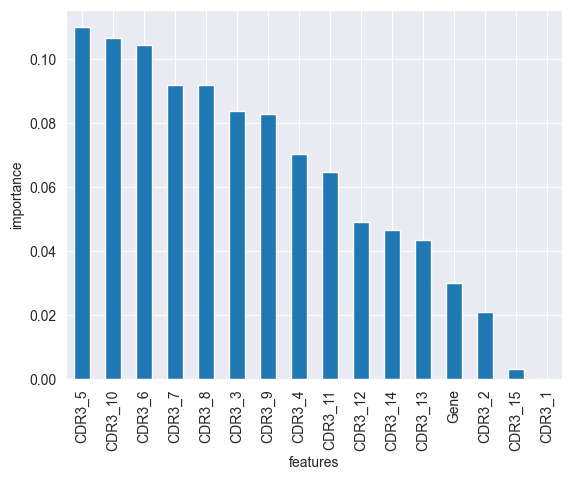

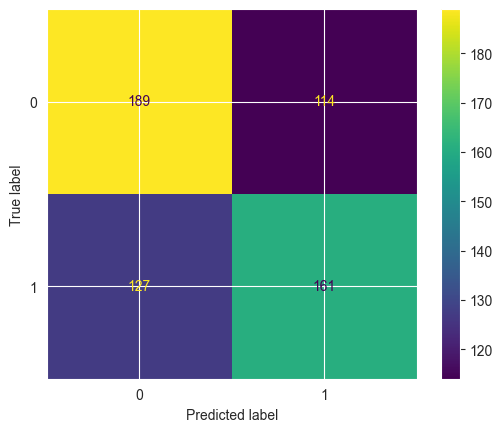

In [7]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
ax = feature_importances.plot.bar()
ax.set_xlabel('features')
ax.set_ylabel('importance')
plt.savefig('plots/MHC_featureimportanceLen15.png', bbox_inches='tight')

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

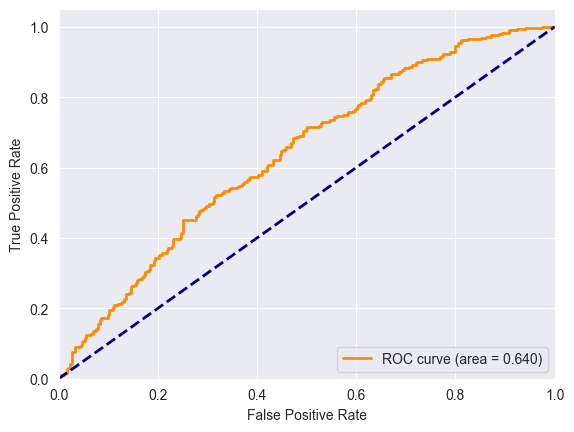

In [8]:
# roc curve
# Predict probabilities
y_prob = clf.predict_proba(X_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('plots/MHC_ROC_HLA.png', bbox_inches='tight')


In [9]:
# # 3d plot
# results = pd.DataFrame(columns=['n_estimators', 'depth', 'accuracy', 'precision', 'recall'])
# results_list = []
# 
# for i in range(1, 100 + 1):
#     for j in range(1, 20 + 1):
#         # initiate model
#         clf2 = RandomForestClassifier(n_estimators=i, max_depth= 14, criterion='gini', 
#                                  max_leaf_nodes=None)
#         # Train the classifier on the training data
#         clf2.fit(X_train, y_train)
#         
#         # evaluate
#         y_pred = clf2.predict(X_test)
#     
#         accuracy = accuracy_score(y_test, y_pred)
#         precision = precision_score(y_test, y_pred)
#         recall = recall_score(y_test, y_pred)
#         
#         results_list.append({'n_estimators': i, 'depth' : j, 'accuracy': accuracy, 'precision': precision, 'recall': recall})
# 
# # Convert the results list into a DataFrame
# results = pd.DataFrame(results_list)
# 
# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(results['depth'], results['n_estimators'], results['accuracy'], c=results['accuracy'], cmap='viridis', linewidth=0.5)
# ax.view_init(20, -20)
# ax.set_xlabel('depth')
# ax.set_ylabel('n_estimators')
# ax.set_zlabel('accuracy')
# plt.tight_layout()
# plt.savefig("plots/modelparam_HLA.png")

In [32]:
# check if there is a difference between only using TRA and only TRB for model accuracy
# filter only TRA
VDJDB_data_filtered6 = VDJDB_data_filtered5.loc[VDJDB_data_filtered5['Gene'] == 1] # filter for TRA
# devide dataset on train and test dataset
yA = VDJDB_data_filtered6['MHC A']
XA = VDJDB_data_filtered6.drop('MHC A', axis=1)

XA_train, XA_test, yA_train, yA_test = train_test_split(XA, yA, test_size=0.2, random_state=50) # splitting dataset

# initiate random forest
clfA = RandomForestClassifier(n_estimators=50, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# train random forest
clfA.fit(XA_train, yA_train)

# Predict probabilities
y_probA = clfA.predict_proba(XA_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fprA, tprA, thresholdsA = roc_curve(yA_test, y_probA)

# Compute AUC
roc_auc_TRA = auc(fprA, tprA)

# filter off TRA
# filter only TRB
VDJDB_data_filtered7 = VDJDB_data_filtered5.loc[VDJDB_data_filtered5['Gene'] == 0] # filter only trb
# devide dataset on train and test dataset
yB = VDJDB_data_filtered7['MHC A']
XB = VDJDB_data_filtered7.drop('MHC A', axis=1)
print(len(yA), len(XA))
XB_train, XB_test, yB_train, yB_test = train_test_split(XB, yB, test_size=0.2, random_state=50) # splitting dataset

# initiate random forest
clfB = RandomForestClassifier(n_estimators=50, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# train random forest
clfB.fit(XB_train, yB_train)

# Predict probabilities
yB_prob = clfB.predict_proba(XB_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fprB, tprB, thresholdsB = roc_curve(yB_test, yB_prob)

# Compute AUC
roc_auc_TRB = auc(fprB, tprB)


print(f'ROC AUC tra: {roc_auc_TRA}, ROC AUC TRB: {roc_auc_TRB}')

854 854
ROC AUC tra: 0.6479154768703598, ROC AUC TRB: 0.5677987742594484


In [11]:
# try sparse coding for data
def encode_df_column_sparse(frame, column, values_dict):
    frame[column] = frame[column].apply(lambda seq: [values_dict[char] for char in seq])


def split_lists_to_columns(frame):
    new_columns = {}
    columns_to_drop = []
    for column in frame.columns:
        if frame[column].apply(lambda x: isinstance(x, list)).any():
            max_list_length = max(frame[column].apply(len))
            for i in range(max_list_length):
                new_column_name = f"{column}_{aa[i]}"
                new_columns[new_column_name] = frame[column].apply(lambda x: x[i] if isinstance(x, list) and len(x) > i else None)
            columns_to_drop.append(column)
    frame = pd.concat([frame, pd.DataFrame(new_columns)], axis=1)
    frame = frame.drop(columns=columns_to_drop)
    return frame

VDJDB_data_filtered8 = pd.concat([HLAA_df_cut, HLAB_df])  

# Sparse coding encoding
aa_encode_sparse = {
    "L": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "N": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "G": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "V": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "E": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "P": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "H": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "K": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "A": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "Y": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "W": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "Q": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "M": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "S": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "C": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "T": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "F": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "R": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    "D": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
}

encode_df_column_sparse(VDJDB_data_filtered8, 'CDR3', aa_encode_sparse)

# encode TRA and TRB and HLA A and HLA B
encode_df_column_binary(VDJDB_data_filtered8, 'Gene', 'TRA')
encode_df_column_binary(VDJDB_data_filtered8, 'MHC A', 'HLA-A')


# split the list
split_list_column_inplace(VDJDB_data_filtered8, 'CDR3')

VDJDB_data_filtered8 = split_lists_to_columns(VDJDB_data_filtered8)


# devide dataset on train and test dataset
ysparse = VDJDB_data_filtered8['MHC A']
Xsparse = VDJDB_data_filtered8.drop('MHC A', axis=1)

Xsparse_train, Xsparse_test, ysparse_train, ysparse_test = train_test_split(Xsparse, ysparse, test_size=0.2, random_state=5) # splitting dataset

# initiate random forest
clfsparse = RandomForestClassifier(n_estimators=50, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# train random forest
clfsparse.fit(Xsparse_train, ysparse_train)

# Predict probabilities
y_probsparse = clfsparse.predict_proba(Xsparse_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fprsparse, tprsparse, thresholdssparse = roc_curve(ysparse_test, y_probsparse)

# Compute AUC
roc_auc_sparse = auc(fprsparse, tprsparse)

# Plot ROC curve
plt.figure()
plt.plot(fprsparse, tprsparse, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_sparse)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('plots/MHC_ROC_sparse.png', bbox_inches='tight')
plt.close()


# Create a series containing feature importances from the model and feature names from the training data
feature_importances_sparse = pd.Series(clfsparse.feature_importances_, index=Xsparse_train.columns).sort_values(ascending=False)

# # Plot a simple bar chart
# ax = feature_importances_sparse.plot.bar()
# ax.set_xlabel('features')
# ax.set_ylabel('importance')
# plt.savefig('plots/MHC_featureimportanceHLA_sparse.png', bbox_inches='tight')


average hydro hlaa: -0.07775971093044266, stdev: 0.545243684211873
average hydro hlab: -0.1723261065943993, stdev: 0.5622360214537145
0.6336175284195087


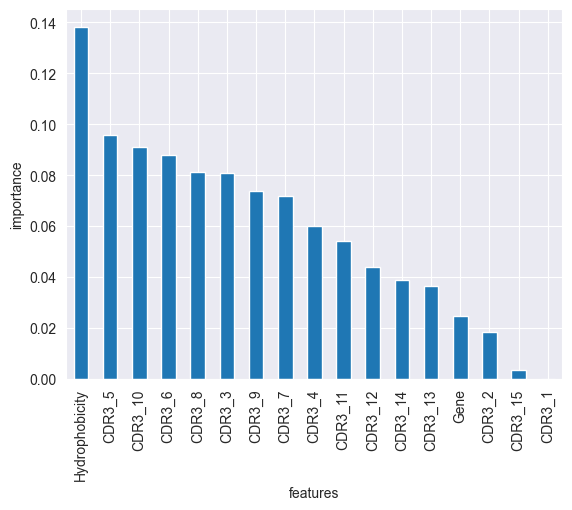

In [16]:
# try adding hydrophobicity as a feature
VDJDB_data_filtered9 = pd.concat([HLAA_df_cut, HLAB_df])  

def calculate_hydrophobicity(sequence):
    kd_hydrophobicity = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5,
        'Q': -3.5, 'E': -3.5, 'G': -0.4, 'H': -3.2, 'I': 4.5,
        'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8, 'P': -1.6,
        'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    total_hydrophobicity = 0.0
    for amino_acid in sequence:
        if amino_acid in kd_hydrophobicity:
            total_hydrophobicity += kd_hydrophobicity[amino_acid]
    return total_hydrophobicity / len(sequence)


def add_hydrophobicity_column(df, sequence_column):
    hydrophobicity_values = []
    for sequence in df[sequence_column]:
        hydrophobicity = calculate_hydrophobicity(sequence)
        hydrophobicity_values.append(hydrophobicity)
    df['Hydrophobicity'] = hydrophobicity_values
    return df


# adding a function to add a column with hydrophobicity value
VDJDB_data_filtered9 = add_hydrophobicity_column(VDJDB_data_filtered9, 'CDR3')

# calculating average and stdev of hydrophobicity
hydrophobicity_HLAA = []
hydrophobicity_HLAB = []
for index, row in VDJDB_data_filtered9.iterrows():
    if row['MHC A'] == 'HLA-A':
        hydrophobicity_HLAA.append(row['Hydrophobicity'])
    elif row['MHC A'] == 'HLA-B':
        hydrophobicity_HLAB.append(row['Hydrophobicity'])
        
print(f'average hydro hlaa: {sum(hydrophobicity_HLAA) / len(hydrophobicity_HLAA)}, stdev: {np.std(hydrophobicity_HLAA)}')
print(f'average hydro hlab: {sum(hydrophobicity_HLAB) / len(hydrophobicity_HLAB)}, stdev: {np.std(hydrophobicity_HLAB)}')

hydrophobicity_df = pd.DataFrame({'Hydrophobicity': hydrophobicity_HLAA + hydrophobicity_HLAB, 'MHC': ['HLA-A'] * len(hydrophobicity_HLAA) + ['HLA-B'] * len(hydrophobicity_HLAA)})

# Create a boxplot to compare the distributions of lengths between the two groups
sns.displot(data=hydrophobicity_df, kind='kde', fill=True, x='Hydrophobicity', hue='MHC', bw_method=0.3)
plt.savefig('plots/Hydrophobicity.png', bbox_inches='tight')
plt.close()

# training model
encode_df_column(VDJDB_data_filtered9, 'CDR3', aa_encoding_series)

# encode TRA and TRB and HLA A and HLA B
encode_df_column_binary(VDJDB_data_filtered9, 'Gene', 'TRA')
encode_df_column_binary(VDJDB_data_filtered9, 'MHC A', 'HLA-A')


# split the list
split_list_column_inplace(VDJDB_data_filtered9, 'CDR3', )

# devide dataset on train and test dataset
yhyd = VDJDB_data_filtered9['MHC A']
Xhyd = VDJDB_data_filtered9.drop('MHC A', axis=1)

Xhyd_train, Xhyd_test, yhyd_train, yhyd_test = train_test_split(Xhyd, yhyd, test_size=0.2, random_state=50) # splitting dataset

# initiate random forest
clfhyd = RandomForestClassifier(n_estimators=100, max_depth=10, 
                             criterion='gini', 
                             max_leaf_nodes=None)

# train random forest
clfhyd.fit(Xhyd_train, yhyd_train)

# Predict probabilities
y_probhyd = clfhyd.predict_proba(Xhyd_test)[:, 1]  # Probability of being in the positive class

# Compute ROC curve
fprhyd, tprhyd, thresholdshyd = roc_curve(yhyd_test, y_probhyd)

# Compute AUC
roc_auc_hyd = auc(fprhyd, tprhyd)
print(roc_auc_hyd)
# Plot ROC curve
plt.figure()
plt.plot(fprhyd, tprhyd, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc_hyd)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('plots/MHC_ROC_hyd.png', bbox_inches='tight')
plt.close()

# Create a series containing feature importances from the model and feature names from the training data
feature_importances_hyd= pd.Series(clfhyd.feature_importances_, index=Xhyd_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
ax = feature_importances_hyd.plot.bar()
ax.set_xlabel('features')
ax.set_ylabel('importance')
plt.savefig('plots/MHC_featureimportanceHLA_hyd.png', bbox_inches='tight')